# Relevant Libraries

In [4]:
# Importing Relevant Libraries
import os, os.path
import importlib
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import qmc
import pyDOE2 as pyd
import seaborn as sns
from matplotlib.pyplot import plot, savefig
import time
import datetime 
from datetime import date
from pyomo.opt import SolverStatus, TerminationCondition
import matplotlib.ticker as mtick
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import logging
from pyomo.environ import *
import yaml
from pathlib import Path

# Source: https://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import sys # Python "sys" documentation: https://docs.python.org/3/library/sys.html

# To reset the default parameters of matplotlib:
import matplotlib as mpl

In [ ]:
# To reset the default parameters of matplotlib:
mpl.rcParams.update(mpl.rcParamsDefault)

# Importing data

In [3]:
# ------------------ Parameters not imported/computed ------------------
i = ['BECCS', 'A/R', 'SCS', 'BC', 'DACCS', 'EW', 'OA', 'DOCCS']
k1 = 0 # Value of first time period
delK = 5 # Time step of optimisation (i.e., length of each period)
N = 4 # Number of segments for piecewise linear approximation
first_year = 2020 # Year corresponding to first time period
last_year = 2100 # Year corresponding to last time period
T = int(1 + (last_year-first_year)/delK) # Number of time periods evaluated, equivalent to 17 if delK = 5 (i.e., 80 years)
k = list(range(k1,T))

# Color Map for later plotting
cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}

## Model input data

In [ ]:
futures_file = Path('PortfolioFiles\sample_of_futures\File Name_15.08.2024.xlsx')

df_input = pd.read_excel(futures_file, index_col ='future_id')

# Dataframe of sampled parameter, df_LHS, is found from df_input by removing the columns that have the same value for all rows
list_repeated = list(df_input[df_input.columns[df_input.nunique() <= 1]])
df_LHS = df_input.drop(list_repeated, axis=1)

# If only the Y_ref is wanted:
Initial_YRef = df_input[df_input.columns.intersection(['Yref_' + el for el in i])]
Initial_YRef.columns = [str(col).split('_')[1] for col in Initial_YRef.columns]
Initial_YRef = Initial_YRef.loc[0].to_dict()

n_lhs = len(df_LHS.T.index)-1 # "-1" because we added future 0 :)

df_LHS

,Energy_DACCS,Energy_DOCCS,Energy_EW,Energy_OA,EnergyL,Land_A/R,Land_BECCS,LandL,ER_A/R,ER_BC,...,CDRRequired,Ymax_A/R,Ymax_BC,Ymax_BECCS,Ymax_DACCS,Ymax_DOCCS,Ymax_EW,Ymax_OA,Ymax_SCS,GeoSt
future_id,,,,,,,,,,,,,,,,,,,,,
0,4.700,2.500,0.5,0.700,2030,0.07,0.040,200000000,-0.230,-0.050,...,400000000000,2000000000,300000000,700000000,5000000000,1000000000,2000000000,1000000000,600000000,4000000000
1,4.700,8.300,12.5,4.767,2045,0.08,0.170,1000000000,-0.230,-0.033,...,1100000000000,5440000000,1560000000,700000000,15500000000,1900000000,2400000000,1000000000,2310000000,20000000000
2,10.000,8.300,0.5,2.733,2045,0.08,0.170,600000000,-0.230,0.083,...,500000000000,3290000000,5340000000,5460000000,17000000000,2800000000,3200000000,5200000000,2120000000,4000000000
3,6.467,2.500,4.5,6.800,2030,0.07,0.170,400000000,-0.202,0.100,...,1000000000000,2430000000,3450000000,10220000000,12500000000,2800000000,3000000000,1000000000,1170000000,12000000000
4,10.000,6.367,12.5,2.733,2030,0.07,0.040,600000000,-0.063,0.017,...,900000000000,4580000000,930000000,10220000000,15500000000,6400000000,3000000000,10800000000,1550000000,12000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,8.233,2.500,8.5,2.733,2030,0.09,0.105,700000000,-0.202,0.017,...,1100000000000,4580000000,4710000000,5460000000,11000000000,7300000000,3600000000,5200000000,2120000000,20000000000
2997,6.467,2.500,12.5,0.700,2050,0.08,0.040,300000000,-0.174,-0.050,...,800000000000,4580000000,930000000,1890000000,15500000000,9100000000,2000000000,3800000000,2120000000,8000000000
2998,10.000,6.367,0.5,4.767,2050,0.09,0.105,200000000,0.020,-0.017,...,500000000000,5440000000,1560000000,9030000000,9500000000,1900000000,2200000000,12200000000,1740000000,16000000000


In [ ]:
with open('metric_names.yaml', 'r') as f:
    metric_names = yaml.safe_load(f)
    
all_metrics_names = metric_names['all_metrics_names']
all_metrics_units = metric_names['all_metrics_units']

metric_names

{'A/R': 'Maximum Capacity of AR',
 'A/R_2050': 'Maximum Capacity A/R by 2050',
 'A/R_2075': 'Maximum Capacity A/R by 2075',
 'A/R_2100': 'Maximum Capacity A/R by 2100',
 'A/R_removed': 'Removals delivered by A/R',
 'BC': 'Maximum Capacity of BC',
 'BC_2050': 'Maximum Capacity BC by 2050',
 'BC_2075': 'Maximum Capacity BC by 2075',
 'BC_2100': 'Maximum Capacity BC by 2100',
 'BC_removed': 'Removals delivered by BC',
 'BECCS': 'Maximum Capacity of BECCS',
 'BECCS_2050': 'Maximum Capacity BECCS by 2050',
 'BECCS_2075': 'Maximum Capacity BECCS by 2075',
 'BECCS_2100': 'Maximum Capacity BECCS by 2100',
 'BECCS_removed': 'Removals delivered by BECCS',
 'CDRRequired': 'Removals Required (2020 - 2100)',
 'Costs': 'Discounted Cumulative Costs',
 'DACCS': 'Maximum Capacity of DACCS',
 'DACCS_2050': 'Maximum Capacity DACCS by 2050',
 'DACCS_2075': 'Maximum Capacity DACCS by 2075',
 'DACCS_2100': 'Maximum Capacity DACCS by 2100',
 'DACCS_removed': 'Removals delivered by DACCS',
 'DOCCS': 'Maximum 

## Model output data

In [29]:
#Reading aggregated results from csv:
output_file = 'PortfolioFiles/results_from_modelling/results_with_geo_10.12.2024.csv'

aggregated_results = pd.read_csv(output_file, index_col ='future_id')

all_metrics_ranges = {key: [] for key in aggregated_results.columns.to_list()}
for metric in aggregated_results.columns:
    all_metrics_ranges[metric].append([aggregated_results[metric].min(),aggregated_results[metric].max()])

total_future = aggregated_results[['Removals','Costs']]
max_resources = aggregated_results[['Land','Energy','Water','Nitrogen','Phosphorous']]   
max_capacity = aggregated_results[i]

removed_per_CDR = aggregated_results[aggregated_results.columns.intersection([el+'_removed' for el in i])]
removed_per_CDR.columns = [str(col).split('_')[0] for col in removed_per_CDR.columns]

max_2050 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2050 for el in i])].T
max_2050.index = [str(col).split('_')[0] for col in max_2050.index]

max_2075 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2075 for el in i])].T
max_2075.index = [str(col).split('_')[0] for col in max_2075.index]

max_2100 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2100 for el in i])].T
max_2100.index = [str(col).split('_')[0] for col in max_2100.index]

solved = aggregated_results.Solved.sum()

aggregated_results

,Energy_DACCS,Energy_DOCCS,Energy_EW,Energy_OA,EnergyL,Land_A/R,Land_BECCS,LandL,ER_A/R,ER_BC,...,OA_2100,DOCCS_2100,BECCS_removed,A/R_removed,SCS_removed,BC_removed,DACCS_removed,EW_removed,OA_removed,DOCCS_removed
future_id,,,,,,,,,,,,,,,,,,,,,
0,4.700,2.500,0.5,0.700,2030,0.07,0.040,200000000,-0.230,-0.050,...,6.982525e+08,0.0,2.730000e+07,1.500000e+11,3.300000e+10,1.050750e+10,1.725001e+11,2.000000e+10,1.396505e+10,10.0
1,4.700,8.300,12.5,4.767,2045,0.08,0.170,1000000000,-0.230,-0.033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.000,8.300,0.5,2.733,2045,0.08,0.170,600000000,-0.230,0.083,...,0.000000e+00,0.0,2.730000e+07,1.936792e+11,1.166000e+11,9.090750e+10,9.878603e+10,1.000000e+01,1.000000e+01,10.0
3,6.467,2.500,4.5,6.800,2030,0.07,0.170,400000000,-0.202,0.100,...,1.000000e+09,0.0,6.636388e+10,1.822000e+11,8.775000e+10,2.255075e+11,3.708048e+11,4.952163e+10,1.785220e+10,10.0
4,10.000,6.367,12.5,2.733,2030,0.07,0.040,600000000,-0.063,0.017,...,1.080000e+10,0.0,1.141955e+11,2.794000e+11,6.200000e+10,2.325750e+10,1.539638e+11,1.000000e+01,2.671831e+11,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,8.233,2.500,8.5,2.733,2030,0.09,0.105,700000000,-0.202,0.017,...,5.200000e+09,0.0,9.600568e+10,2.794000e+11,1.590000e+11,1.538075e+11,2.970480e+11,6.484983e+08,1.140903e+11,10.0
2997,6.467,2.500,12.5,0.700,2050,0.08,0.040,300000000,-0.174,-0.050,...,3.800000e+09,0.0,8.970591e+10,2.213269e+11,1.590000e+11,4.185750e+10,1.197776e+11,7.040105e+09,1.612920e+11,10.0
2998,10.000,6.367,0.5,4.767,2050,0.09,0.105,200000000,0.020,-0.017,...,1.220000e+10,0.0,2.730000e+07,1.624998e+11,1.000000e+11,3.900750e+10,1.487922e+10,1.081155e+10,1.727746e+11,10.0


# 3. Plotting & Analysis included in Manuscript & Supplementary Information

## Summary Statistics

In [ ]:
# ======================== Summary Statistics of max capacity of each CDR option by 2100 ======================== 
data = max_2100.T.copy()

# We can also compare output and input data: Ymax stores the input max potential
Ymax = pd.DataFrame() 
for CDR in i:
    Ymax[CDR] = aggregated_results.loc[:,'Ymax_%s' %CDR].div(1e9)
    
# This is because the dataframes were defined as: max_time = (Max capacity in indicated time period) - (Initial Capacity Installed) 
for CDR in data.columns:
    data.loc[:,CDR] += Initial_YRef[CDR]
        
summary = data.div(1e9).describe(include = 'all')
summary.loc['input_max'] = Ymax.max()
summary.loc['input_min'] = Ymax.min()
summary.loc['input_range'] = summary.loc['input_max'] - summary.loc['input_min']

summary.loc['IQR'] = summary.loc['75%']-summary.loc['25%']

# Computing and normalising different metrics 
summary.loc['IQR_norm'] = summary.loc['IQR'].div(summary.loc['IQR'].max()) #IQR divided by largest IQR
summary.loc['std_norm'] = summary.loc['std'].div(summary.loc['std'].max()) #std divided by largest std
summary.loc['median_to_max_norm'] = (summary.loc['max']-data.div(1e9).median())/summary.loc['max'] # (output max - median)/(output max) 
summary.loc['median_to_max_range'] = (summary.loc['max']-data.div(1e9).median())/(summary.loc['max']-summary.loc['min']) # (output max - median)/(output max) 
summary.loc['median_to_max_norm_input'] = (summary.loc['max']-data.div(1e9).median())/summary.loc['input_max'] # (output max - median)/(input max) 

for CDR in i:
    summary.loc['IQR_norm_2',CDR] = summary.loc['IQR',CDR]/summary.loc['max',CDR] 

pd.option_context('display.float_format', '{:,.2f}'.format)
                  
summary

,BECCS,A/R,SCS,BC,DACCS,EW,OA,DOCCS
count,"2,726.00","2,726.00","2,726.00","2,726.00","2,726.00","2,726.00","2,726.00","2,726.00"
mean,2.59,3.33,1.47,2.70,7.71,1.35,4.40,0.08
std,2.57,0.88,0.54,2.00,3.02,1.39,4.27,0.68
min,0.00,1.98,0.60,0.00,0.00,0.00,0.00,0.00
25%,0.37,2.43,0.98,0.93,5.44,0.00,0.00,0.00
50%,1.89,3.29,1.55,2.82,7.65,1.01,3.80,0.00
75%,4.12,4.40,1.93,4.71,9.98,2.60,8.00,0.00
max,10.00,4.40,2.31,5.97,12.50,3.80,13.60,9.10
input_max,11.41,5.87,2.31,5.97,18.50,3.80,13.60,9.10
input_min,0.70,2.00,0.60,0.30,5.00,2.00,1.00,1.00


## Violin Charts

Key Resources:
- [Seaborn violing plots Documentation](https://seaborn.pydata.org/generated/seaborn.violinplot.html)
- [.stack()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html#pandas.DataFrame.stack) a dataframe -> add columns as multi-index
- [sns.set_theme()](https://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme)

### Max Capacity per time period

Maximum capacity of BECCS in 2050 is 10.0 GtCO2/yr
Interquartile range of DACCS in 2100 is: 5.4 to 10.0 GtCO2/yr


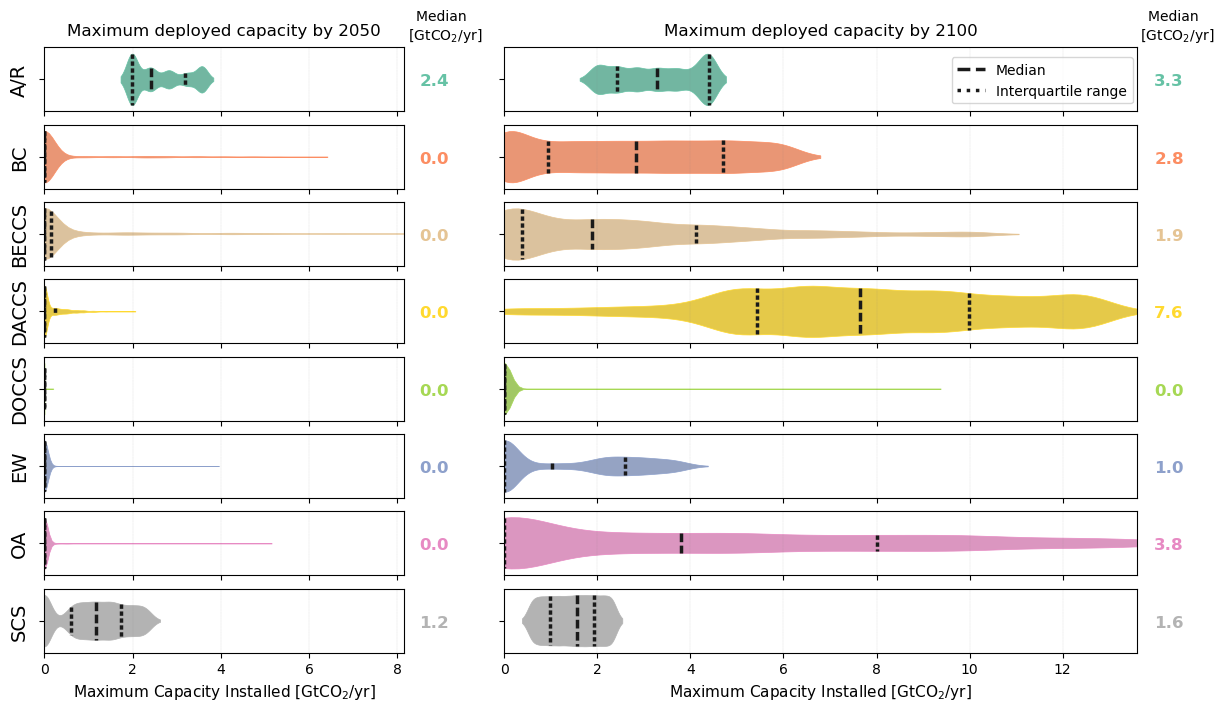

In [ ]:
periods = [2050,2100] # Only admits 2 periods > run cell below to visualise 2075 data.
i.sort()
# ================================== For plotting purposes ==================================
cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}
mpl.rcParams.update(mpl.rcParamsDefault)

y_legend = 1.05
y_subfig = y_legend + 0.01

fig = plt.figure(layout='constrained', figsize=(12, 7))
subfigs = fig.subfigures(1, len(periods), wspace=0.07, width_ratios=[0.63, 1])

#plt.suptitle('Distribution of maximum deployed capacity per CDR Option at different time periods', size=13, y=y_subfig+0.03)
'''fig.legend(handles=[mlines.Line2D([], [], linestyle='--', color='k', label='Median',linewidth=1.8),
                           mlines.Line2D([], [], linestyle=':', color='k', label='Interquartile range',linewidth=1.4)], 
           fontsize =10, loc='upper center', bbox_to_anchor=(0.5,y_legend), ncol=2)'''
# ================================== For plotting purposes ==================================
sub = 0
time = max_2050.sort_index().copy()    
for year in periods:
    if year == 2075:
        time = max_2075.sort_index().copy() 
    elif year == 2100:
        time = max_2100.sort_index().copy()     
    
    # This is because the dataframes were defined as: max_time = (Max capacity in indicated time period) - (Initial Capacity Installed) 
    for CDR in time.index:
        time.loc[CDR,:] += Initial_YRef[CDR]
        
    df = pd.DataFrame(time.T.stack())
    df = df.rename(columns={0:"Maximum Capacity"})
    df = df.reset_index()
    df["Maximum Capacity"] = df["Maximum Capacity"].mul(1e-9)
    df = df.rename(columns={"level_1":"CDR_opt"})
    
    #subfigs[sub].suptitle('Maximum deployed capacity by %d' %year, fontsize=12, y = y_subfig)
    axes = subfigs[sub].subplots(8, 2, width_ratios=[12,1], sharex='col')

    r = 0
    axes[r,0].set_title('Maximum deployed capacity by %d' %year, fontsize=12, y = y_subfig)
    if sub == 0:
        axes[r,1].set_title('Median \n [GtCO$_2$/yr]', fontsize = 10, loc='center', x=0.9)
    else:
        axes[r,1].set_title('Median \n [GtCO$_2$/yr]', fontsize = 10, loc='center', x=0.5)
    for CDR in i:
        plot = df[df.CDR_opt == CDR] 
        
        # Adding Median information
        median_all = df[df.CDR_opt == CDR]['Maximum Capacity'].median()
        axes[r,1].annotate('%.1f' %median_all, xy=(0.5,0.4), xytext=(0.1,0.4), color = color_dict[CDR], annotation_clip=False, fontsize=12, weight='bold')
        axes[r,1].spines[['right', 'top','left','bottom']].set_visible(False)
        axes[r,1].set_xticks([])
        axes[r,1].set_yticks([])
        axes[r,1].set_ylabel(ylabel = "")
        axes[r,1].set_xlabel(xlabel = "")
    
        # Adding Violin Plots
        sns.violinplot(data=plot, x="Maximum Capacity",ax=axes[r,0], label=CDR, color = color_dict[CDR],linewidth=0.5, 
                       legend = False, linecolor= color_dict[CDR], density_norm='count', inner="quart", inner_kws={"color": "k", "linewidth": 2.5})
        axes[r,0].set_xticks([0,2,4,6,8,10,12])

        if year == 2050:
            axes[r,0].set_xlim(0,1e-9*max_capacity.max().max()*0.6)
        else: 
            axes[r,0].set_xlim(0,1e-9*max_capacity.max().max())
            
        axes[r,0].set_xlabel(xlabel = "")
        axes[r,0].xaxis.grid(color='grey', linestyle='--', linewidth=0.1, zorder=1)
        
        if sub == 0:
            axes[r,0].set_ylabel(ylabel=CDR, fontsize = 14)

        if r == 7:
            axes[r,0].set_xlabel(xlabel = "Maximum Capacity Installed [GtCO$_2$/yr]", fontsize = 11)
        r += 1
    
    sub += 1

axes[0,0].legend(handles=[mlines.Line2D([], [], linestyle='--', color='k', label='Median',linewidth=2.5),
                           mlines.Line2D([], [], linestyle=':', color='k', label='Interquartile range',linewidth=2.5)], 
           fontsize =10, loc='upper center', bbox_to_anchor=(0.85,0.95), ncol=1)

print('Maximum capacity of BECCS in 2050 is %.1f GtCO2/yr' %(1e-9*max_2050.loc['BECCS',:].max()))
print("Interquartile range of DACCS in 2100 is:", round(df[df.CDR_opt == 'DACCS']['Maximum Capacity'].quantile(0.25),1), "to", round(df[df.CDR_opt == 'DACCS']['Maximum Capacity'].quantile(0.75),1), "GtCO2/yr")

plt.show()
plt.close('all')

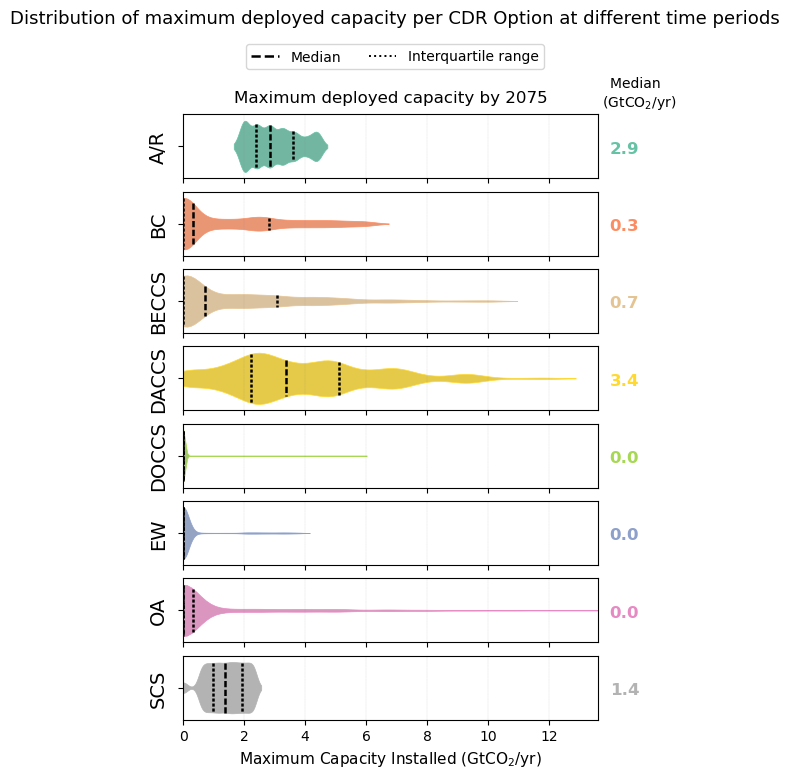

In [ ]:
# ONLY FOR 2075

periods = [2075]
# ================================== For plotting purposes ==================================
cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}
mpl.rcParams.update(mpl.rcParamsDefault)

y_legend = 1.05
y_subfig = y_legend + 0.01

fig = plt.figure(layout='constrained', figsize=(5, 7))
#subfigs = fig.subfigures(1, len(periods), wspace=0.07, width_ratios=[0.63, 1])

plt.suptitle('Distribution of maximum deployed capacity per CDR Option at different time periods', size=13, y=y_subfig+0.03)
fig.legend(handles=[mlines.Line2D([], [], linestyle='--', color='k', label='Median',linewidth=1.8),
                           mlines.Line2D([], [], linestyle=':', color='k', label='Interquartile range',linewidth=1.4)], 
           fontsize =10, loc='upper center', bbox_to_anchor=(0.5,y_legend), ncol=2)
# ================================== For plotting purposes ==================================
sub = 0
time = max_2050.copy()    
for year in periods:
    if year == 2075:
        time = max_2075.copy() 
    elif year == 2100:
        time = max_2100.copy()     
    
    for CDR in time.index:
        time.loc[CDR,:] += Initial_YRef[CDR]
        
    df = pd.DataFrame(time.T.stack())
    df = df.rename(columns={0:"Maximum Capacity"})
    df = df.reset_index()
    df["Maximum Capacity"] = df["Maximum Capacity"].mul(1e-9)
    df = df.rename(columns={"level_1":"CDR_opt"})
    
    #subfigs[sub].suptitle('Maximum deployed capacity by %d' %year, fontsize=12, y = y_subfig)
    axes = fig.subplots(8, 2, width_ratios=[12,1], sharex='col')

    r = 0
    axes[r,0].set_title('Maximum deployed capacity by %d' %year, fontsize=12, y = y_subfig)
    if sub == 0:
        axes[r,1].set_title('Median \n (GtCO$_2$/yr)', fontsize = 10, loc='center', x=0.9)
    else:
        axes[r,1].set_title('Median \n (GtCO$_2$/yr)', fontsize = 10, loc='center', x=0.5)
    for CDR in i:
        plot = df[df.CDR_opt == CDR] 
        #print(df[df.CDR_opt == CDR]['Maximum Capacity'].max())
        # Adding Median information
        median_all = df[df.CDR_opt == CDR]['Maximum Capacity'].median()
        axes[r,1].annotate('%.1f' %median_all, xy=(0.5,0.4), xytext=(0.1,0.4), color = color_dict[CDR], annotation_clip=False, fontsize=12, weight='bold')
        axes[r,1].spines[['right', 'top','left','bottom']].set_visible(False)
        axes[r,1].set_xticks([])
        axes[r,1].set_yticks([])
        axes[r,1].set_ylabel(ylabel = "")
        axes[r,1].set_xlabel(xlabel = "")
    
        # Adding Violin Plots
        sns.violinplot(data=plot, x="Maximum Capacity",ax=axes[r,0], label=CDR, color = color_dict[CDR],linewidth=0.5, 
                       legend = False, linecolor= color_dict[CDR], density_norm='count', inner="quart", inner_kws={"color": "k", "linewidth": 1.8})
        axes[r,0].set_xticks([0,2,4,6,8,10,12])

        if year == 2050:
            axes[r,0].set_xlim(0,1e-9*max_capacity.max().max()*0.6)
        else: 
            axes[r,0].set_xlim(0,1e-9*max_capacity.max().max())
        axes[r,0].set_xlabel(xlabel = "")
        axes[r,0].xaxis.grid(color='grey', linestyle='--', linewidth=0.1, zorder=1)
        
        if sub == 0:
            axes[r,0].set_ylabel(ylabel=CDR, fontsize = 14)

        if r == 7:
            axes[r,0].set_xlabel(xlabel = "Maximum Capacity Installed (GtCO$_2$/yr)", fontsize = 11)
        r += 1
    
    sub += 1

plt.show()
plt.close('all')

### Scenarios

Methodology:
- Select an uncertainty (or combination of) that is to be evaluated. Available parameters are described in cell "all_metric_ranges" below.
- Select a relevant range to observe 
- Identify the FutureIDs that meet the criteria
- Visualise using violin plots only with those future IDs vs all futures

#### Available Scenarios

In [ ]:
# Describes parameters that can be investigated. Range is reported in brackets: [[minimum, maximum]]
all_metrics_ranges

{'Energy_DACCS': [[4.7, 10.0]],
 'Energy_DOCCS': [[2.5, 8.3]],
 'Energy_EW': [[0.5, 12.5]],
 'Energy_OA': [[0.7, 6.8]],
 'EnergyL': [[2030.0, 2050.0]],
 'Land_A/R': [[0.07, 0.09]],
 'Land_BECCS': [[0.04, 0.17]],
 'LandL': [[200000000.0, 1000000000.0]],
 'ER_A/R': [[-0.23, 0.02]],
 'ER_BC': [[-0.05, 0.1]],
 'ER_BECCS': [[-0.15, 0.15]],
 'ER_DACCS': [[0.05, 0.15]],
 'ER_DOCCS': [[0.05, 0.15]],
 'ER_EW': [[-0.05, 0.05]],
 'ER_OA': [[-0.05, 0.1]],
 'ER_SCS': [[-0.23, -0.01]],
 'CDRRequired': [[400000000000.0, 1100000000000.0]],
 'Ymax_A/R': [[2000000000.0, 5870000000.0]],
 'Ymax_BC': [[300000000.0, 5970000000.0]],
 'Ymax_BECCS': [[700000000.0, 11410000000.0]],
 'Ymax_DACCS': [[5000000000.0, 18500000000.0]],
 'Ymax_DOCCS': [[1000000000.0, 9100000000.0]],
 'Ymax_EW': [[2000000000.0, 3800000000.0]],
 'Ymax_OA': [[1000000000.0, 13600000000.0]],
 'Ymax_SCS': [[600000000.0, 2310000000.0]],
 'GeoSt': [[4000000000.0, 20000000000.0]],
 'Solved': [[0, 1]],
 'Removals': [[0.0, 1100000000000.0012]],
 

In [ ]:
# ===== Defining Colors for different groups of parameters =====
cmap=plt.get_cmap('Set2')

color_plots_dict = {'Energy_DACCS': 'orange', 'Energy_DOCCS': 'orange', 'Energy_EW': 'orange', 'Energy_OA': 'orange', 'EnergyL': 'orange',
               'Land_AR': 'mediumseagreen', 'Land_BECCS': 'mediumseagreen', 'LandL': 'mediumseagreen',
               'ER_AR': 'mediumorchid', 'ER_BC': 'mediumorchid', 'ER_BECCS': 'mediumorchid', 'ER_DACCS': 'mediumorchid', 'ER_DOCCS': 'mediumorchid', 'ER_EW': 'mediumorchid', 'ER_OA': 'mediumorchid', 'ER_SCS': 'mediumorchid',
               'CDRRequired': 'khaki', 'Ymax_AR': 'saddlebrown', 'Ymax_BC': 'saddlebrown', 'Ymax_BECCS': 'saddlebrown', 'Ymax_DACCS': 'saddlebrown', 'Ymax_DOCCS': 'saddlebrown', 'Ymax_EW': 'saddlebrown', 'Ymax_OA': 'saddlebrown', 'Ymax_SCS': 'saddlebrown',
               'GeoSt': 'khaki', 'Solved': 'khaki', 'Removals': 'khaki', 'Costs': 'deepskyblue',
               'A/R': cmap(0.1), 'BC': cmap(0.2), 'BECCS': cmap(0.8), 'DACCS': cmap(0.7), 'DOCCS': cmap(0.5), 'EW': cmap(0.3), 'OA': cmap(0.4), 'SCS': cmap(0.9),
            'Land': 'khaki', 'Energy': 'orange', 'Water': 'lightblue', 'Nitrogen': 'tan', 'Phosphorous': 'tan'}

In [ ]:
# Extract range into dictionary with lists: dict = {'parameter' : [[min, max]]}
def extract_range(all_metrics_ranges,metric_interest,minimum,maximum):
    minimum_value = all_metrics_ranges[metric_interest][0][0]
    maximum_value = all_metrics_ranges[metric_interest][0][1]
    if minimum == 1:
        interest = [minimum_value, minimum_value+(maximum_value-minimum_value)*maximum]
    elif maximum == 1:
        interest = [minimum_value+(maximum_value-minimum_value)*minimum, maximum_value]
    else: 
        interest = [minimum_value+(maximum_value-minimum_value)*minimum, minimum_value+(maximum_value-minimum_value)*maximum]
    
    return {metric_interest : [interest]}

# Extract range into dictionary with tuples: dict = {'parameter' : (min, max)}
def extract_range_tuples(all_metrics_ranges,metric_interest,minimum,maximum):
    minimum_value = all_metrics_ranges[metric_interest][0][0]
    maximum_value = all_metrics_ranges[metric_interest][0][1]
    if minimum == 1:
        interest = (minimum_value, minimum_value+(maximum_value-minimum_value)*maximum)
    elif maximum == 1:
        interest = (minimum_value+(maximum_value-minimum_value)*minimum, maximum_value)
    else: 
        interest = (minimum_value+(maximum_value-minimum_value)*minimum, minimum_value+(maximum_value-minimum_value)*maximum)
    
    return {metric_interest : interest}

#### Visualising Experience Parameters for all CDR options

<Figure size 1200x700 with 0 Axes>

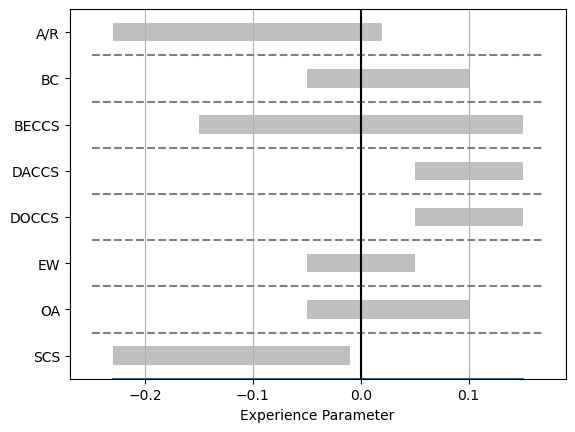

In [ ]:
# =========================================== Visualising Experience Parameters for all CDR options ===========================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Code source: https://stackoverflow.com/questions/29451057/how-to-do-a-range-bar-graph-in-matplotlib
cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}

def plot_rect(data, color, delta=0.4):
    """data is a dictionary, {"Label":(low,hi), ... }
    return a drawing that you can manipulate, show, save etc"""

    yspan = len(data)
    yplaces = [.5+i for i in range(yspan)]
    ylabels = sorted(data.keys(),reverse=True)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_yticks(yplaces)
    ax.set_yticklabels(ylabels)
    ax.set_ylim((0,yspan))

    # later we'll need the min and max in the union of intervals
    low, hi =  data[ylabels[0]]
    for pos, label in zip(yplaces,ylabels):
        start, end = data[label]
        ax.add_patch(patches.Rectangle((start,pos-delta/2.0),end-start,delta,facecolor=color))
        #ax.add_patch(patches.Rectangle((start,pos-delta/2.0),end-start,delta,facecolor=color_dict[label]))
        if start<low : low=start
        if end>hi : hi=end

    # little small trick, draw an invisible line so that the x axis
    # limits are automatically adjusted...
    ax.plot((low,hi),(0,0))

    # now get the limits as automatically computed
    xmin, xmax = ax.get_xlim()
    # and use them to draw the hlines in your example
    ax.hlines(range(1,yspan),xmin,xmax, linestyles = 'dashed', color = 'grey')
    ax.axvline(color='k')
    # the vlines are simply the x grid lines
    ax.grid(axis='x')
    # eventually return what we have done
    return ax

# ===============================================================================================
ranges_ER = {}
ranges_ER_interest = {}
for CDR in i:
    ranges_ER[CDR] = (all_metrics_ranges['ER_'+CDR][0][0], all_metrics_ranges['ER_'+CDR][0][1])
    ranges_ER_interest[CDR] = extract_range_tuples(all_metrics_ranges,'ER_'+CDR,minimum=1,maximum=0.25)['ER_'+CDR]
    
ax = plot_rect(ranges_ER,(0.5,0.5,0.5,0.5))
#ax = plot_rect(ranges_ER_interest,'mediumorchid')
ax.set_xlabel('Experience Parameter')

plt.show()
plt.close('all') 

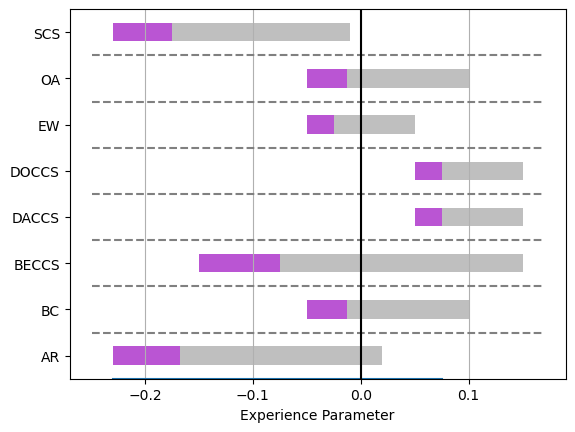

In [ ]:
# =========================================== Visualising Experience Parameters for all CDR options for futures of interest ===========================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Code source: https://stackoverflow.com/questions/29451057/how-to-do-a-range-bar-graph-in-matplotlib
def plot_rect_two(data_all, data_interest, color_all, color_interest, delta=0.4):
    """data is a dictionary, {"Label":(low,hi), ... }
    return a drawing that you can manipulate, show, save etc"""

    yspan = len(data_all)
    yplaces = [.5+i for i in range(yspan)]
    ylabels = sorted(data_all.keys())

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_yticks(yplaces)
    ax.set_yticklabels(ylabels)
    ax.set_ylim((0,yspan))

    # later we'll need the min and max in the union of intervals
    low, hi =  data_all[ylabels[0]]
    for pos, label in zip(yplaces,ylabels):
        start, end = data_all[label]
        ax.add_patch(patches.Rectangle((start,pos-delta/2.0),end-start,delta,facecolor=color_all))
        
        start, end = data_interest[label]
        ax.add_patch(patches.Rectangle((start,pos-delta/2.0),end-start,delta,facecolor=color_interest))
        
        if start<low : low=start
        if end>hi : hi=end

    # little small trick, draw an invisible line so that the x axis
    # limits are automatically adjusted...
    ax.plot((low,hi),(0,0))

    # now get the limits as automatically computed
    xmin, xmax = ax.get_xlim()
    # and use them to draw the hlines in your example
    ax.hlines(range(1,yspan),xmin,xmax, linestyles = 'dashed', color = 'grey')
    ax.axvline(color='k')
    # the vlines are simply the x grid lines
    ax.grid(axis='x')
    # eventually return what we have done
    return ax
# ===============================================================================================
ranges_ER = {}
ranges_ER_interest = {}
for CDR in i:
    ranges_ER[CDR] = (all_metrics_ranges['ER_'+CDR][0][0], all_metrics_ranges['ER_'+CDR][0][1])
    ranges_ER_interest[CDR] = extract_range_tuples(all_metrics_ranges,'ER_'+CDR,minimum=1,maximum=0.25)['ER_'+CDR]
    
ax = plot_rect_two(ranges_ER,ranges_ER_interest,(0.5,0.5,0.5,0.5),'mediumorchid')
ax.set_xlabel('Experience Parameter')

plt.show()
plt.close('all') 

#### 3 Scenarios: Violin & Boxplots

901 Futures meet the selected citeria (incl. NaN futures)
901 Futures meet the selected citeria (incl. NaN futures)
48 Futures meet the selected citeria (incl. NaN futures)


<Figure size 1410x1000 with 0 Axes>

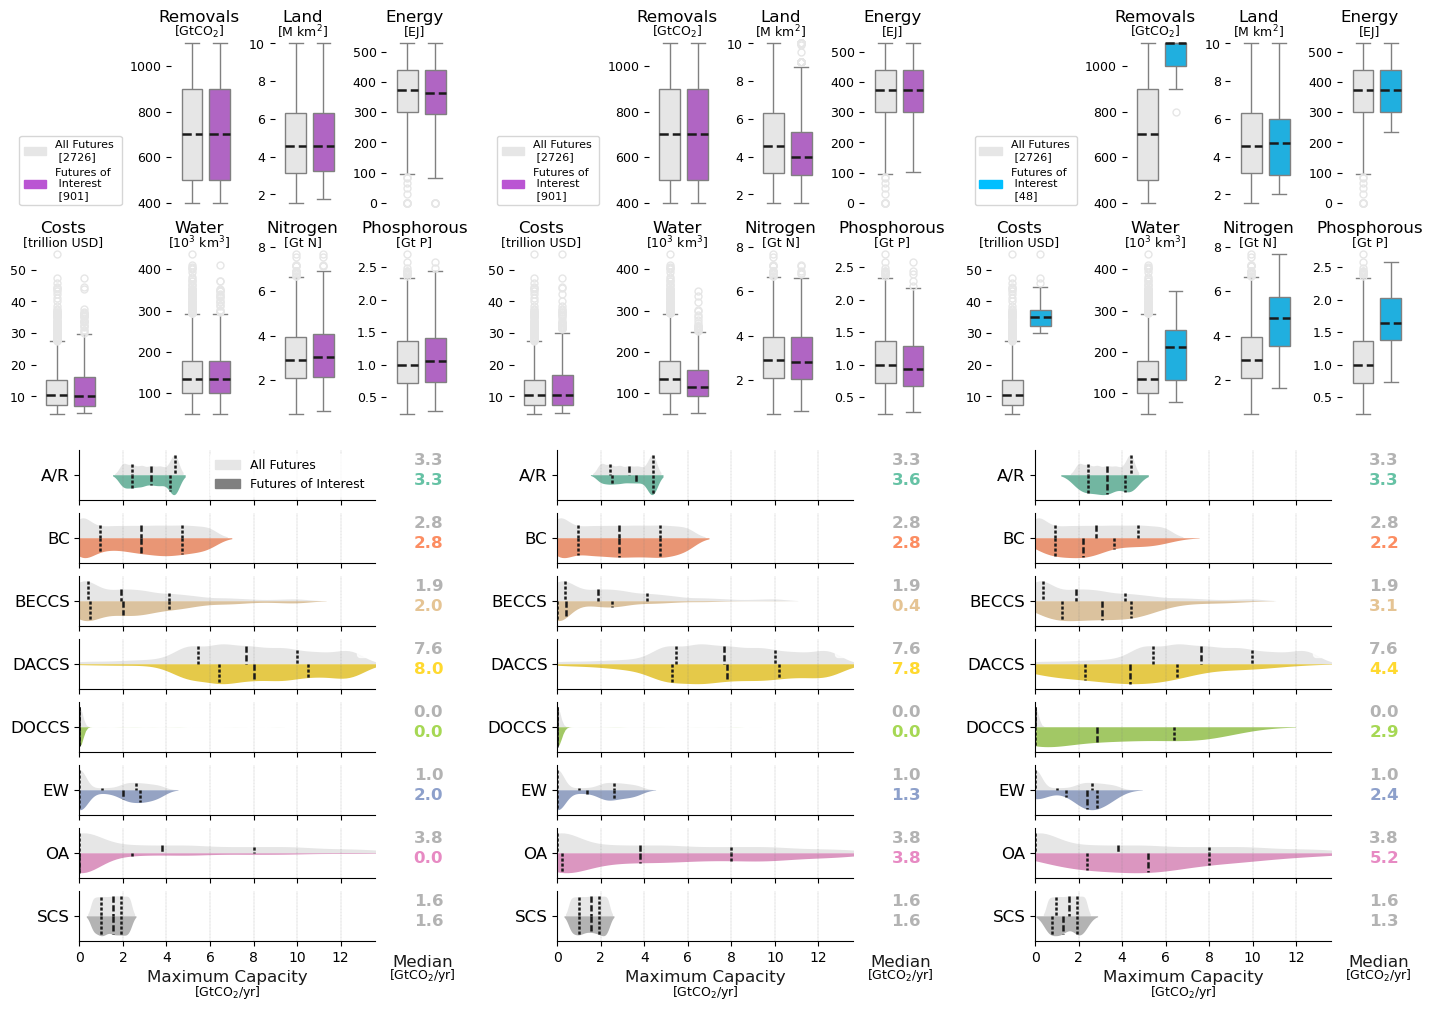

In [ ]:
# ==================================================================================================
# DIFFERENT COLORS & SHARED LEGEND
# ==================================================================================================

# ============================================ Input ===============================================
#parameters = {'LandL':[1,0.25], 'EnergyL':[0.75,1], 'Removals':[0.75,1]} # Only admits 3 items
parameters = {'ER_OA':[1,0.25], 'ER_BECCS':[1,0.25], 'Costs':[0.5,1]} # Only admits 3 items

color_plots_metrics = {'LandL':'mediumseagreen', 'EnergyL':'orange', 'Removals':'khaki', 'Costs':'deepskyblue', 
               'ER_OA':'mediumorchid', 'ER_BECCS':'mediumorchid'}

# ====================================== For plotting purposes ======================================
cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}

fig = plt.figure(layout='constrained', figsize= (14.1,10)) #(13.6, 7.8)
subfigs = fig.subfigures(2, 3, wspace=0.05, hspace=0.04, width_ratios=[1,1,1], height_ratios=[3,4])

legend_y = 1.08
subfig_title = legend_y+0.01

# ==================================================================================================
metrics_of_interest = {}
index_parameter = 0

for parameter in list(parameters.keys()): 
    metrics_of_interest = extract_range(all_metrics_ranges,metric_interest=parameter,minimum=parameters[parameter][0],maximum=parameters[parameter][1])
    color_plots = color_plots_metrics[parameter]
    
    # ================================== Identifying Futures of Interest ==================================
    list_of_futures = []
    remaining_futures = aggregated_results.copy()
    for metric in metrics_of_interest:
        if len(metrics_of_interest)==1:
            title_plot = ["%s from %.1E to %.1E (%s)" %(all_metrics_names[metric], metrics_of_interest[metric][0][0], metrics_of_interest[metric][0][1], all_metrics_units[metric])]
        else:
            title_plot = [list(metrics_of_interest.keys())]

        for futureID in remaining_futures.index:
            value = remaining_futures.loc[futureID, metric]
            if (value >= metrics_of_interest[metric][0][0]) & (value <= metrics_of_interest[metric][0][1]):
                list_of_futures += [futureID]
            else:
                remaining_futures = remaining_futures.drop(futureID)
    list_of_futures_in = remaining_futures.index.to_list()
    list_of_futures_out = list(set(aggregated_results.index.to_list()) - set(list_of_futures_in)) # List of futures that are outside ranges specified in "metrics_of_interest"

    # ================================== Plotting Violins ==================================
    #subfigs[0].suptitle('Violin Plots of Maximum deployed capacity per CDR Option', fontsize=11, y = subfig_title)
    axsLeft = subfigs[1,index_parameter].subplots(8, 2, width_ratios=[13,1],sharex='col')

    c=0
    metric = max_capacity
    if metric is max_capacity:
        interest = "Capacity"
        x_lim = max_capacity.max().max()
    else:
        interest = "Cumulative Experience"
        x_lim = max_experience.max(axis=1).max()

    df = pd.DataFrame(metric.stack())
    df = df.rename(columns={0:"Maximum %s (GtCO2/yr)" %interest})
    df["Maximum %s (GtCO2/yr)" %interest] = df["Maximum %s (GtCO2/yr)" %interest].mul(1e-9)
    df = df.reset_index()

    # Delete futures that are out of the ranges of interest
    df_new = df.copy()
    for futureID in list_of_futures_out:
        df_new = df_new[df_new.future_id != futureID]

    df_new["class"] = 'futures of interest'
    df["class"] = 'all futures'
    df_plot = pd.concat([df, df_new])
    df_plot = df_plot.rename(columns={"level_1":"CDR_opt"})

    r = 0
    #axsLeft[r,1].set_title('Median \n (GtCO$_2$/yr)', fontsize = 10, loc='center')

    for CDR in ['A/R', 'BC', 'BECCS', 'DACCS', 'DOCCS','EW','OA','SCS']:
        plot = df_plot[df_plot.CDR_opt == CDR] 
        median_all = df_plot.loc[(df_plot['class']=='all futures') & (df_plot['CDR_opt']==CDR)]['Maximum Capacity (GtCO2/yr)'].median()
        median_interest = df_plot.loc[(df_plot['class']=='futures of interest') & (df_plot['CDR_opt']==CDR)]['Maximum Capacity (GtCO2/yr)'].median()
        axsLeft[r,1].annotate('%.1f' %median_all, xy=(0.5,0.7), xytext=(0.1,0.7), color = (0.7,0.7,0.7,1), annotation_clip=False, fontsize=12, weight='bold')
        axsLeft[r,1].annotate('%.1f' %median_interest, xy=(0.5,0.3), xytext=(0.1,0.3), color = color_dict[CDR], annotation_clip=False, fontsize=12, weight='bold')
        axsLeft[r,1].spines[['right', 'top','left','bottom']].set_visible(False)
        axsLeft[r,1].set_xticks([])
        axsLeft[r,1].set_yticks([])
        axsLeft[r,1].set_ylabel(ylabel = "")
        axsLeft[r,1].set_xlabel(xlabel = "")

        sns.violinplot(data=plot, y = "CDR_opt", x="Maximum %s (GtCO2/yr)" %(interest), hue="class", split = True, palette={'futures of interest': color_dict[CDR], 'all futures':(0.9,0.9,0.9,0.5)}, linewidth=0,
                       ax = axsLeft[r,0], density_norm='count', legend = True, inner="quart", inner_kws={"color": "k", "linewidth": 1.8})
        #violin.set_yticklabels(violin.get_yticks(), size = 14)
        axsLeft[r,0].yaxis.set_tick_params(labelsize = 12)
        axsLeft[r,0].set_xlim(0,x_lim*1e-9)
        axsLeft[r,0].set_ylabel(ylabel = "")
        axsLeft[r,0].set_xlabel(xlabel = "")
        axsLeft[r,0].xaxis.grid(color='grey', linestyle='--', linewidth=0.2, zorder=1)
        axsLeft[r,0].legend(labels="", edgecolor='white',facecolor='white')
        axsLeft[r,0].spines[['right', 'top']].set_visible(False)

        if r == 7:
            axsLeft[r,0].set_xlabel(xlabel = "Maximum %s" %(interest), fontsize = 12, color = 'k')
            axsLeft[r,0].text(x=0.5, y=-1.04, s='[GtCO$_2$/yr]', horizontalalignment='center', verticalalignment='center', transform=axsLeft[r,0].transAxes, fontsize = 9)
            
            axsLeft[r,1].set_xlabel(xlabel = 'Median', fontsize = 12, color = 'k', labelpad = 10)
            axsLeft[r,1].text(x=0.5, y=-0.7, s='[GtCO$_2$/yr]', horizontalalignment='center', verticalalignment='center', transform=axsLeft[r,1].transAxes, fontsize = 9)

            #handles, labels = axsLeft[r,0].get_legend_handles_labels()
        r += 1

    if index_parameter ==0:
        axsLeft[0,0].legend(handles=[mpatches.Patch(color=(0.9,0.9,0.9,1), label='All Futures'),
                               mpatches.Patch(color=(0.5,0.5,0.5,1), label='Futures of Interest')],
                      fontsize = 9, loc='upper left', bbox_to_anchor=(0.42,1.05), ncol=1, facecolor='white', edgecolor='white')    

        '''axsLeft[1,0].legend(handles=[#mpatches.Patch(color=(0.9,0.9,0.9,1), label='All Futures [%d]' %solved),
                               #mpatches.Patch(color=(0.5,0.5,0.5,1), label='Futures of Interest [%d]' %len(list_of_futures_in)),
                               mlines.Line2D([], [], linestyle='--', color='k', label='Median',linewidth=1.4),
                               mlines.Line2D([], [], linestyle=':', color='k', label='Interquartile range',linewidth=1)],
                            fontsize =10, loc='upper left', bbox_to_anchor=(0.55,1), ncol=1, facecolor='white', edgecolor='white')'''

    print(len(list_of_futures_in), 'Futures meet the selected citeria (incl. NaN futures)')

    # ================================== Plotting Boxplots ==================================
    #subfigs[0,index_parameter].suptitle(all_metrics_names[parameter], fontsize=11)
    n_rows = 2
    n_cols = 4
    axsRight = subfigs[0,index_parameter].subplots(n_rows, n_cols)

    table_plotting = aggregated_results[['Removals','Land','Energy','Costs','Water','Nitrogen','Phosphorous']].copy()
    table_plotting = table_plotting[table_plotting['Removals'] != 0] # Need to drop futures that were not solved
    metrics = table_plotting.columns.to_list()

    conversion = {'Removals':1e9,'Land':1e8,'Energy':1e9,'Costs':1e12,'Water':1e3,'Nitrogen':1e3,'Phosphorous':1e3}
    units_conver = {'Removals':'GtCO$_2$','Land':'M km$^2$','Energy':'EJ','Costs':'trillion USD','Water':'10$^3$ km$^3$','Nitrogen':'Gt N','Phosphorous':'Gt P'}
    for column in table_plotting.columns:
        table_plotting[column] = table_plotting[column].div(conversion[column])

    # Delete futures that are out of the ranges of interest
    df_new = table_plotting.copy()
    for futureID in list_of_futures_out:
        df_new = df_new[df_new.index != futureID]

    df_new["class"] = 'futures of interest'
    table_plotting["class"] = 'all futures'
    df_plot = pd.concat([table_plotting, df_new])

    N_off = (0,0) # If (1,3) --> c = 0; if (0,0) --> c = 1; 
    axsRight[N_off].spines[['right', 'top','left','bottom']].set_visible(False)
    axsRight[N_off].set_xticks([])
    axsRight[N_off].set_yticks([])
    axsRight[N_off].set_xlim(0,1)
    axsRight[N_off].set_ylim(0,1)
    #axsRight[N_off].legend(handles=[mpatches.Patch(color=(0.9,0.9,0.9,1), label='All Futures [%d]' %solved), mpatches.Patch(color=color_plots, label='Futures of Interest [%d]' %len(list_of_futures_in))], 
                         #fontsize = 9, loc='center', bbox_to_anchor=(0.5, 0.9), ncol=1, edgecolor='white',facecolor='white')
    #text = 'Metric evaluated: \n %s \n Number of futures of interest = %d \n (out of %d solved)' %(title_plot[0],len(list_of_futures_in),solved)
    #axsRight[0,0].text(0.5, 1, text, dict(ha='center', va='center', fontsize=10, color='k'), wrap=True)

    r = 0
    c = 1
    for metric in metrics:
        plot = df_plot[[metric, 'class']]
        sns.boxplot(data=plot, y=metric, hue="class", gap=0, ax=axsRight[r,c], legend = False, widths = 0.3, 
                    palette = {'futures of interest':color_plots,'all futures':(0.9,0.9,0.9,0.5)}, 
                    flierprops=dict(marker='o',  markersize=5, linestyle='none', markeredgecolor=(0.9,0.9,0.9,1)), 
                    linecolor=(0.5,0.5,0.5,1), medianprops = dict(linestyle='--', linewidth=1.8, color='k'))

        axsRight[r,c].spines[['right', 'top','left','bottom']].set_visible(False)
        axsRight[r,c].set_xticks([])
        axsRight[r,c].yaxis.set_tick_params(labelsize = 9)
        axsRight[r,c].set_ylabel(ylabel='')
        #axsRight[r,c].set_title('%s \n [%s]' %(metric,units_conver[metric]), loc='center', x=0.4, y=1.03 fontsize = 12)

        axsRight[r,c].set_title('%s' %(metric), loc='center', x=0.4, y=1.03, fontsize = 12)
        axsRight[r,c].text(x=0.4, y=1.02, s="[%s]" %units_conver[metric], horizontalalignment='center', verticalalignment='center', transform=axsRight[r,c].transAxes, size = 9)
        if c == n_cols-1:
            c = 0
            r += 1
        else:
             c += 1
    # ================================== Shared Legend ==================================
    axsRight[N_off].legend(handles=[mpatches.Patch(color=(0.9,0.9,0.9,1), label='All Futures \n [%d]' %solved),
                               #mpatches.Patch(color=(0.5,0.5,0.5,1), label='Futures of Interest \n [%d]' %len(list_of_futures_in))], # To use 'All Futures' = grey
                                mpatches.Patch(color=color_plots, label='Futures of \n Interest \n [%d]' %len(list_of_futures_in))], # To use 'All Futures' = color of plots
                                #mpatches.Patch(color='white', label=''), 
                               #mlines.Line2D([], [], linestyle='--', color='k', label='Median',linewidth=1.4),
                               #mlines.Line2D([], [], linestyle=':', color='k', label='Interquartile range',linewidth=1)], 
                      fontsize = 8, loc='lower center', ncol=1)#, bbox_to_anchor=(0.25,0.45))

    #axsRight[r, 3].legend(handles=[mpatches.Patch(color=(0.9,0.9,0.9,1), label='All Futures'),mpatches.Patch(color=color_plots, label='Futures of Interest')], fontsize =9, loc='upper center')#, bbox_to_anchor=(0.5,legend_y), ncol=2)

    #subfigs[1].legend(handles=[mpatches.Patch(color=(0.9,0.9,0.9,1), label='All Futures'),mpatches.Patch(color=color_plots, label='Futures of Interest')], fontsize =9, loc='upper center', bbox_to_anchor=(0.5,legend_y+0.02), ncol=2)
    index_parameter += 1
    
plt.show()
plt.close('all') 

In [ ]:
dataframe = max_2100.T.copy()
# This is because the dataframes were defined as: max_time = (Max capacity in indicated time period) - (Initial Capacity Installed) 
for CDR in dataframe.columns:
    dataframe.loc[:,CDR] += Initial_YRef[CDR]
    
# ======================= Summary Statistics =======================
parameters = {'OA_2100':[1,0.25]}

for parameter in list(parameters.keys()): 
    metrics_of_interest = extract_range(all_metrics_ranges,metric_interest=parameter,minimum=parameters[parameter][0],maximum=parameters[parameter][1])
    
    # ================================== Identifying Futures of Interest ==================================
    list_of_futures = []
    remaining_futures = aggregated_results.copy()
    for metric in metrics_of_interest:
        if len(metrics_of_interest)==1:
            title_plot = ["%s from %.1E to %.1E (%s)" %(all_metrics_names[metric], metrics_of_interest[metric][0][0], metrics_of_interest[metric][0][1], all_metrics_units[metric])]
        else:
            title_plot = [list(metrics_of_interest.keys())]

        for futureID in remaining_futures.index:
            value = remaining_futures.loc[futureID, metric]
            if (value >= metrics_of_interest[metric][0][0]) & (value <= metrics_of_interest[metric][0][1]):
                list_of_futures += [futureID]
            else:
                remaining_futures = remaining_futures.drop(futureID)
    list_of_futures_in = remaining_futures.index.to_list()
    list_of_futures_out = list(set(aggregated_results.index.to_list()) - set(list_of_futures_in)) # List of futures that are outside ranges specified in "metrics_of_interest"

    for futureID in list_of_futures_out: dataframe = dataframe[dataframe.index != futureID]

summary_scenario = dataframe.div(1e9).describe(include = 'all')
summary_scenario.loc['median'] = dataframe.div(1e9).median()
summary_scenario.loc['IQR'] = summary_scenario.loc['75%']-summary_scenario.loc['25%']

#Normalising the IQR based on largest value
summary_scenario.loc['IQR_norm'] = summary_scenario.loc['IQR'].div(summary.loc['IQR'].max()) # Note that we are dividing by the general summary
summary_scenario.loc['std_norm'] = summary_scenario.loc['std'].div(summary.loc['std'].max()) # Note that we are dividing by the general summary

#pd.option_context('display.float_format', '{:,.2f}'.format)
print("Summary of results for scenarios based on parameters %s" %parameters.keys())                  
summary_scenario

Summary of results for scenarios based on parameters dict_keys(['OA_2100'])


,BECCS,A/R,SCS,BC,DACCS,EW,OA,DOCCS
count,"1,328.00","1,328.00","1,328.00","1,328.00","1,328.00","1,328.00","1,328.00","1,328.00"
mean,2.57,3.35,1.48,2.49,8.54,1.24,0.69,0.06
std,2.67,0.87,0.55,2.06,2.62,1.40,0.98,0.60
min,0.00,1.98,0.60,0.00,0.00,0.00,0.00,0.00
25%,0.13,2.43,0.98,0.30,6.50,0.00,0.00,0.00
50%,1.89,3.29,1.55,2.19,8.60,0.00,0.00,0.00
75%,4.17,4.30,1.93,4.08,10.66,2.60,1.00,0.00
max,10.00,4.40,2.31,5.97,12.50,3.80,3.38,8.20
median,1.89,3.29,1.55,2.19,8.60,0.00,0.00,0.00
IQR,4.05,1.87,0.95,3.78,4.16,2.60,1.00,0.00


## Scatter plots of Key metrics

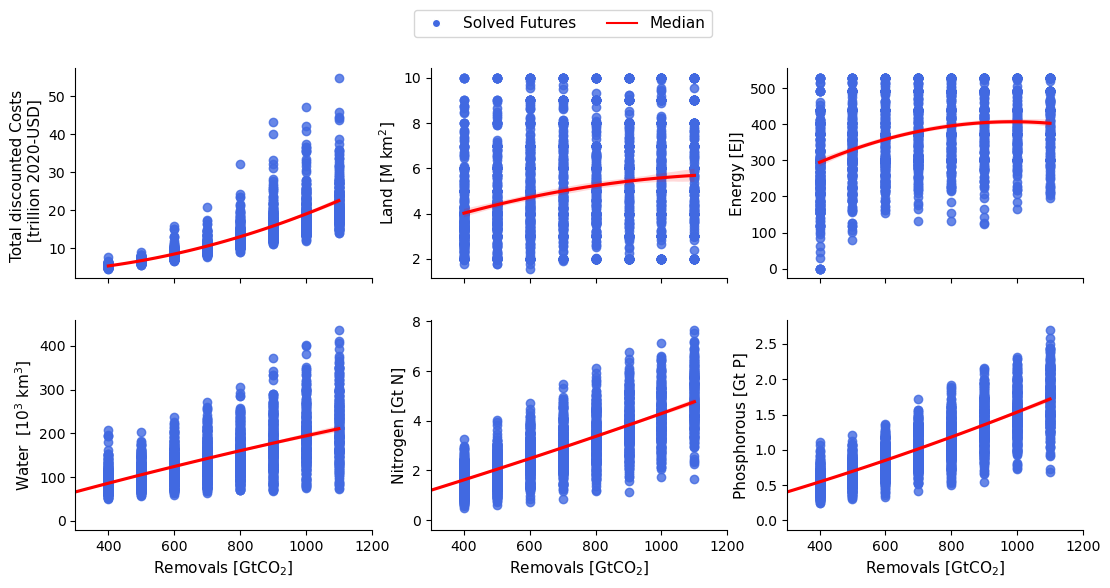

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.regplot.html
cmap=plt.get_cmap('Set2')

scatter = pd.concat([total_future,max_resources], axis=1)

conversion = {'Removals':1e9,'Land':1e8,'Energy':1e9,'Costs':1e12,'Water':1e3,'Nitrogen':1e3,'Phosphorous':1e3}
units_conver = {'Removals':'GtCO$_2$','Land':'M km$^2$','Energy':'EJ','Costs':'trillion USD','Water':'10$^3$ km$^3$','Nitrogen':'Gt N','Phosphorous':'Gt P'}
for column in scatter.columns:
    scatter[column] = scatter[column].div(conversion[column])
    
att = list(scatter.columns)#.remove('Removals') # Save name of columns to plot in the y axis
att.remove('Removals') # Remove "Removals" as this will be the x axis
scatter = pd.concat([scatter, max_capacity], axis=1) # Add max_capacity to identify which CDR is "dominant"
y_axes_names = {"Costs":"Total discounted Costs \n [trillion 2020-USD]", "Land":"Land [M km$^2$]", "Energy":"Energy [EJ]", "Water":"Water  [10$^3$ km$^3$]", "Nitrogen":"Nitrogen [Gt N]", "Phosphorous":"Phosphorous [Gt P]"}

# Saving color code for tech with most capacity deployed per future
eh = max_capacity.idxmax(axis=1) # For each future_id, save the CDR option with max capacity
col = []
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5), np.nan:(0, 0, 0, 1)}
for futureID,rows in scatter.iterrows():
    scatter.loc[futureID,'Largest'] = eh[futureID]
    col += [color_dict[eh[futureID]]]
scatter['Color'] = col

n_rows = 2
n_cols = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(13, 6),sharex=True)
#fig.tight_layout()
#plt.suptitle("Scatter plots with color referring to most deployed CDR option", size = 10, y = 1.05)

r = 0
c = 0
for column_name in att:
    #scatter.plot.scatter(ax=axes[r,c], x='Removals',y=column_name,color=scatter.Color)
    sns.regplot(ax=axes[r,c], data=scatter, x="Removals", y=column_name, order = 2, ci=99, color = 'royalblue', line_kws=dict(color="r"))
    axes[r,c].set_ylabel(ylabel=y_axes_names[column_name], fontsize = 11)
    if r == 0:
        axes[r,c].set_xlabel(xlabel = "")
    else:
        axes[r,c].set_xlabel(xlabel = "Removals [GtCO$_2$]", fontsize = 11)
    if c == n_cols-1:
        c = 0
        r += 1
    else:
         c += 1

for col in range(0,n_cols):
    for row in range(0,n_rows):
        #axes[row,col].get_xaxis().set_ticks([])
        #axes[row,col].ticklabel_format(axis='y', style='sci',scilimits=(3,5))
        #axes[row,col].ticklabel_format(axis='x', style='sci',scilimits=(9,10))
        #axes[row,col].xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
        axes[row,col].spines[['right', 'top']].set_visible(False)
        axes[row,col].set_xlim(300, 1200)
        
        #axes[row,col].set_axisbelow(True)
        #axes[row,col].yaxis.grid(color='gray', linestyle='dashed')

fig.legend(handles=[mlines.Line2D([], [], color='white', marker='o', markerfacecolor = 'royalblue', label='Solved Futures'), mlines.Line2D([], [], color='r', label='Median')], fontsize = 11, loc='upper center', bbox_to_anchor=(0.5, 0.99),ncol=2)
#plt.savefig('Figures_Results/Scatters_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")      
plt.show()
plt.close('all')


## Key Results (no plotting)

### Average number of options for large removals

Code outputs the largest number of options for futures with >= 900 GtCO2 of NE required.

It needs two dataframes: "max_2100" & "total_future"

In [ ]:
number_of_options_2100 = pd.DataFrame(max_2100.fillna(0).astype(bool).sum(axis=0)) #NaN are considered as 0
number_of_options_2100.index.names = ['future_id']
number_of_options_2100 = number_of_options_2100.rename(columns={0:"Max_options"})

for futureID in number_of_options_2100.index:
    number_of_options_2100.loc[futureID,"Removals"] = total_future.loc[futureID, "Removals"]*1e-9
number_of_options_2100 = number_of_options_2100.sort_values(by=['Removals'],ascending=False)

number_of_options_2100[number_of_options_2100.Removals >= 900]["Max_options"].mean()

6.779881656804734

### DOCCS deployment

In [ ]:
max_capacity.dropna().sort_values(by=['DOCCS'],ascending = False)

print('DOCCS capacity above 1GtCO2 %d times' %aggregated_results[max_capacity['DOCCS']>=1e9].count()['DOCCS'])
print('Out of which %d (or %d percent) are in futures where removals are above 925 GtCO2 (or > 75 percent)' %(aggregated_results[max_capacity['DOCCS']>=1e9]['Removals'][aggregated_results['Removals'].div(1e9)>=925].count(), 
                                                                                       100*aggregated_results[max_capacity['DOCCS']>=1e9]['Removals'][aggregated_results['Removals'].div(1e9)>=925].count()/aggregated_results[max_capacity['DOCCS']>=1e9].count()['DOCCS']))

# aggregated_results[max_capacity['DOCCS']>=1e9]['Removals'][aggregated_results['Removals'].div(1e9)>=925].count() #Count of futures where DOCCS > 1GtCO2 and Removals > 925

DOCCS capacity above 1GtCO2 51 times
Out of which 34 (or 66 percent) are in futures where removals are above 925 GtCO2 (or > 75 percent)


In [ ]:
mid_costs =  0.5*(all_metrics_ranges['Costs'][0][1]-all_metrics_ranges['Costs'][0][0]) + all_metrics_ranges['Costs'][0][0]
print('DOCCS capacity above 1GtCO2 %d times' %aggregated_results[max_capacity['DOCCS']>=1e9].count()['DOCCS'])
print('Out of which %d futures are >50 percent of costs' %aggregated_results[(aggregated_results['DOCCS']>=1e9)&(aggregated_results['Costs']>=mid_costs)]['DOCCS'].count())

DOCCS capacity above 1GtCO2 51 times
Out of which 32 futures are >50 percent of costs


## Percentage of futures in which an option is deployed

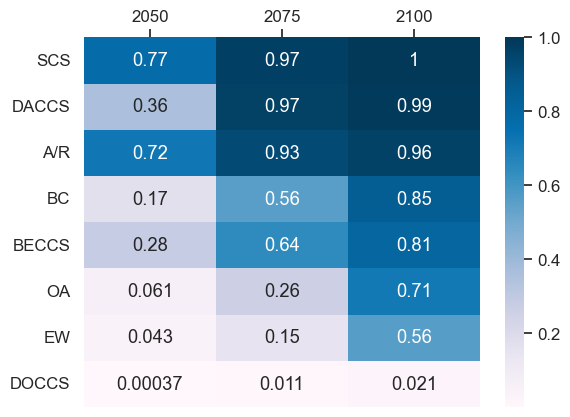

In [ ]:
percentage_in = pd.DataFrame()
for CDR in i:
    try: 
        percentage_in.loc[CDR,2050] = 1-max_2050.loc[CDR].value_counts(normalize=True)[0] # This gives the normalised count of 0s, ignoring the NaN
    except:
        percentage_in.loc[CDR,2050] = 1 # "except" is required as there might be no 0s
    try: 
        percentage_in.loc[CDR,2075] = 1-max_2075.loc[CDR].value_counts(normalize=True)[0] # This gives the normalised count of 0s, ignoring the NaN
    except:
        percentage_in.loc[CDR,2075] = 1
    try: 
        percentage_in.loc[CDR,2100] = 1-max_2100.loc[CDR].value_counts(normalize=True)[0] # This gives the normalised count of 0s, ignoring the NaN
    except:
        percentage_in.loc[CDR,2100] = 1

percentage_in = percentage_in.sort_values(by=[2100], ascending=False)
sns.set(font_scale=1.1)
dataplot = sns.heatmap(percentage_in, cmap=plt.get_cmap('PuBu'), annot=True,) # colourmap: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
#dataplot.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 15)
dataplot.xaxis.tick_top()

#plt.suptitle("Percentage of futures in which an option is deployed", size = 10, y = 0.95)
#plt.savefig('Figures_Results/Percentages_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")

plt.show()

## Analysis with EMA Workbench

Key Resources for Exploratory Modelling Analysis (EMA):
- [Modules in Exploratory modeling framework documentation](https://emaworkbench.readthedocs.io/en/latest/api_index.html)
- [EMA Workbench tutorial](https://emaworkbench.readthedocs.io/en/latest/basic_tutorial.html) 
- Documentation on [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/)
- [Kwakkel (2017)](https://www.sciencedirect.com/science/article/pii/S1364815217301251) article describing EMA Workbench

In [ ]:
# List of model outputs that could be of interest for the analysis
list(aggregated_results.columns)

['Energy_DACCS',
 'Energy_DOCCS',
 'Energy_EW',
 'Energy_OA',
 'EnergyL',
 'Land_AR',
 'Land_BECCS',
 'Land_DACCS',
 'LandL',
 'LR_AR',
 'LR_BC',
 'LR_BECCS',
 'LR_DACCS',
 'LR_DOCCS',
 'LR_EW',
 'LR_OA',
 'LR_SCS',
 'NERequired',
 'Ymax_AR',
 'Ymax_BC',
 'Ymax_BECCS',
 'Ymax_DACCS',
 'Ymax_DOCCS',
 'Ymax_EW',
 'Ymax_OA',
 'Ymax_SCS',
 'Solved',
 'Removals',
 'Costs',
 'AR',
 'BC',
 'BECCS',
 'DACCS',
 'DOCCS',
 'EW',
 'OA',
 'SCS',
 'Land',
 'Energy',
 'Water',
 'Nitrogen',
 'Phosphorous']

### Feature Scoring

Feature scoring is a methodology for identifying what model inputs (in machine learning terminology, “features”) have the greatest relationship to the outputs. The relationship is not necessarily linear, but rather can be any arbitrary linear or non-linear relationship ([source](https://tmip-emat.github.io/source/emat.analysis/feature-scoring.html#:~:text=Feature%20scoring%20is%20a%20methodology,linear%20or%20non%2Dlinear%20relationship.)).

Various feature scoring techniques are included in the scikit–learn library ([Pedregosa et al., 2011](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?ref=https:/)). The workbench provides a convenient function that wraps some of the scikit-learn feature scoring techniques. 

To perform feature scoring on one of the outcomes of interes, we first need to preprocess the experiment array.

#### Feature Scoring on whether a future is solved or not

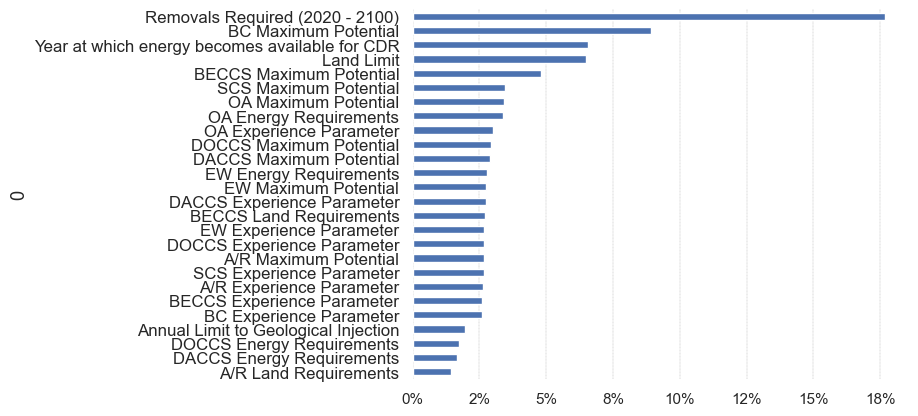

In [ ]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import RuleInductionType

x = df_LHS.T.copy()
#x = x[x.columns.drop(list(x.filter(regex='ER')))] # Remove non-relevant uncertainties that could only randomly explain the outcome

y = aggregated_results['Solved']#==0 # If '==0' is added, this would convert the list from finary to True/false = equivalent!

fs, _ = feature_scoring.get_rf_feature_scores(x,y,mode=RuleInductionType.REGRESSION)

n_to_plot = 26

cmap=plt.get_cmap('PuBu')
example = dict.fromkeys(fs.head(n_to_plot).index.tolist(),2)
r = 0
for keys in example.keys():
    example.update({keys:cmap(r)})
    r += 1

    fs[1] = fs[1].div(0.01)
fs = fs.rename(index=Uncertainties)
fs = fs.sort_values(by=[1], ascending=True)

'''The parameter first from the fs list is by far the most important factor affecting the terminal value of the outcome. 
This result is only applicable for a single outcome of interest. It might be convenient to have some insight into the 
sensitivity of each of the four outcomes of interest to the various uncertainties as well as the policy.'''
ax = fs.head(n_to_plot).plot.barh(legend=False)
ax.set_facecolor("white")
ax.grid(False)
ax.spines[['right', 'top','bottom','left']].set_visible(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.tick_params(axis='x', labelsize = 11)
ax.xaxis.grid(color='grey', linestyle='--', linewidth=0.2, zorder=1)
#plt.savefig('Figures_Results/Features_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")

#sns.heatmap(fs.head(5), annot=True,cmap='PuBu')
plt.show()
plt.close('all')
#fs

#### Feature Scoring on outliers

number of outliers: 64
max outlier value: 53865010759635.76
min outlier value: 27928893798669.027


C:\Users\rodq\AppData\Local\anaconda3\lib\site-packages\ema_workbench\analysis\feature_scoring.py:226: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(x, y)


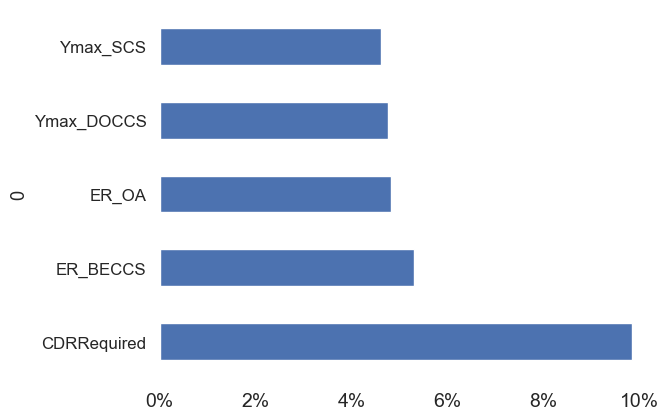

In [ ]:
metric_of_interest = "Costs"

scatter = pd.concat([total_future,max_resources], axis=1)
scatter = scatter[scatter['Removals'] != 0] # Need to drop futures that were not solved

outliers = find_outliers_IQR(scatter[metric_of_interest])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))

y = pd.DataFrame({'Outlier_%s' %metric_of_interest: [0]*aggregated_results.index.size},index = aggregated_results.index.tolist())

for out in outliers.index:
    y.loc[out,'Outlier_%s' %metric_of_interest] = 1

x = df_LHS.T
#x = x[x.columns.drop(list(x.filter(regex='ER')))] # Remove non-relevant uncertainties that could only randomly explain the outcome

#y = aggregated_results['Solved']#==0 # If '==0' is added, this would convert the list from binary to True/false = equivalent!

fs, _ = feature_scoring.get_rf_feature_scores(x,y,mode=RuleInductionType.REGRESSION)

fs[1] = fs[1].div(0.01)

'''The parameter first from the fs list is by far the most important factor affecting the terminal value of the outcome. 
This result is only applicable for a single outcome of interest. It might be convenient to have some insight into the 
sensitivity of each of the four outcomes of interest to the various uncertainties as well as the policy.'''

ax = fs.head(5).plot.barh(legend=False)
ax.set_facecolor("white")
ax.grid(False)
ax.spines[['right', 'top','bottom','left']].set_visible(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.tick_params(axis='x', labelsize = 14)
plt.savefig('Figures_Results/Features_outliers_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")

#sns.heatmap(fs.head(5), annot=True,cmap='PuBu')
plt.show()
plt.close('all')

#### Feature Scoring on a single outcome metric

This one is different than before as "NaN" data for the futures that were not solved needs to be dropped. 

In [ ]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import RuleInductionType

x = df_LHS.T
#x = x[x.columns.drop(list(x.filter(regex='ER')))] # Remove non-relevant uncertainties that could only randomly explain the outcome

y = aggregated_results['Land']

x = x.drop([n for n in y.loc[pd.isna(y)].index]) # Drop futures that were not solved
y = y.dropna() # Drop futures that were not solved

fs, _ = feature_scoring.get_rf_feature_scores(x,y,mode=RuleInductionType.REGRESSION)

'''The parameter first from the fs list is by far the most important factor affecting the terminal value of the outcome. 
This result is only applicable for a single outcome of interest. It might be convenient to have some insight into the 
sensitivity of each of the four outcomes of interest to the various uncertainties as well as the policy.'''

fs

,1
0,
LandL,0.421940
Ymax_BECCS,0.079109
ER_BECCS,0.065307
CDRRequired,0.060038
Land_BECCS,0.054219
Ymax_AR,0.028349
Ymax_BC,0.018118
Ymax_SCS,0.017708
ER_OA,0.017449


#### Feature Scoring on Drivers of (large) Adoption for CDR option i

C:\Users\rodq\AppData\Local\anaconda3\lib\site-packages\ema_workbench\analysis\feature_scoring.py:226: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(x, y)


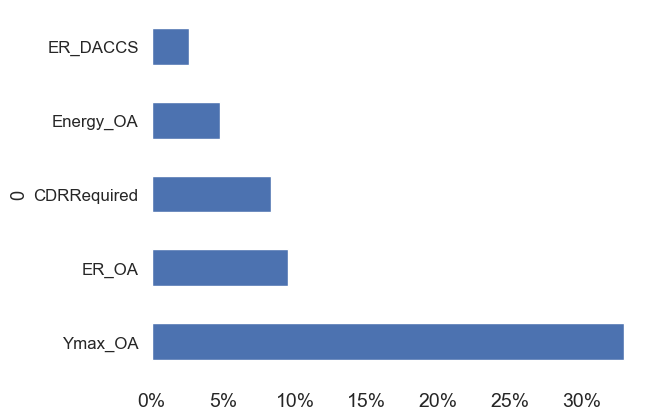

,1
0,
Ymax_OA,32.975178
ER_OA,9.519416
CDRRequired,8.330510
Energy_OA,4.725797
ER_DACCS,2.576395
Ymax_BC,2.455751
ER_BECCS,2.440962
Ymax_DACCS,2.435923
ER_BC,2.344010


In [ ]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import RuleInductionType

x = df_LHS.T

metric_of_interest = "OA"
mid_value = 0.5*(max_capacity[metric_of_interest].max() + max_capacity[metric_of_interest].min())

y = pd.DataFrame()
for futureID in max_capacity.index:
    if max_capacity.loc[futureID,metric_of_interest] >= mid_value:
        y.loc[futureID,'%s above %.1f GtCO2' %(metric_of_interest,mid_value*1e-9)] = 1
    else:
        y.loc[futureID,'%s above %.1f GtCO2' %(metric_of_interest,mid_value*1e-9)] = 0

fs, _ = feature_scoring.get_rf_feature_scores(x,y,mode=RuleInductionType.REGRESSION)
fs[1] = fs[1].div(0.01)

ax = fs.head(5).plot.barh(legend=False)
ax.set_facecolor("white")
ax.grid(False)
ax.spines[['right', 'top','bottom','left']].set_visible(False)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.tick_params(axis='x', labelsize = 14)
plt.savefig('Figures_Results/Features_outliers_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")

plt.show()
plt.close('all')
fs

#### General Feature Scoring: Max capacity

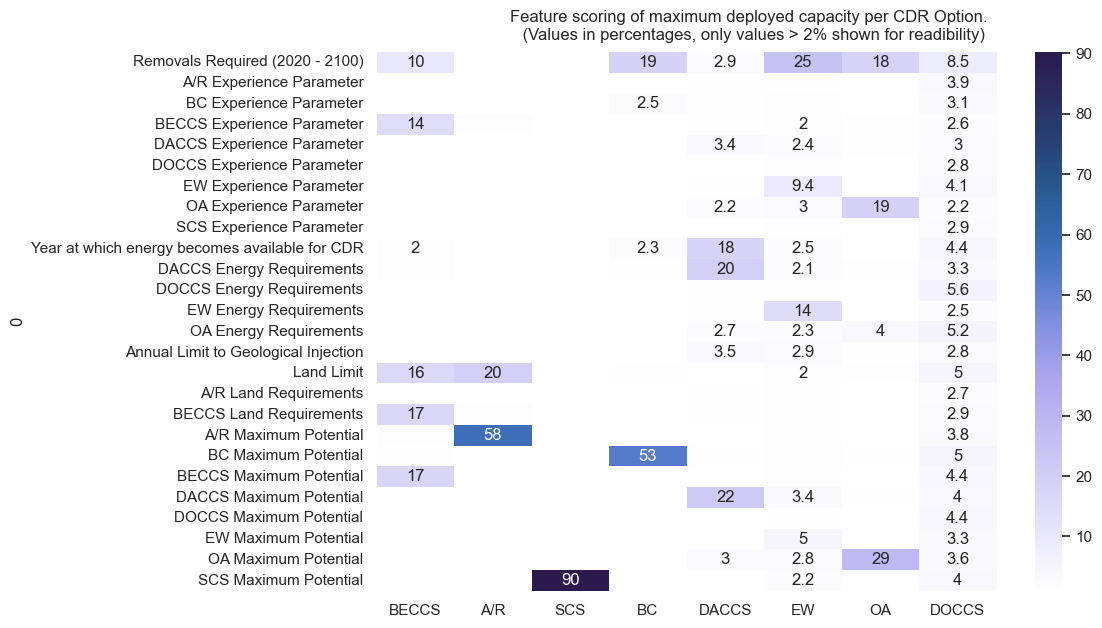

In [ ]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns
from cmcrameri import cm # https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf

x = df_LHS.T
y = max_capacity.copy()

x = x.drop([n for n in y.loc[pd.isna(y['A/R'])].index]) # Drop futures that were not solved
y = y.dropna() # Drop futures that were not solved

fs_all = feature_scoring.get_feature_scores_all(x,y)
fs_all = fs_all.rename(index=Uncertainties)
fs_all = fs_all.div(0.01)

sns.set(font_scale=1)
plt.subplots(figsize=(10,7))
plt.suptitle('Feature scoring of maximum deployed capacity per CDR Option. \n (Values in percentages, only values > 2% shown for readibility)', size=12, y=0.94)
#dataplot = sns.heatmap(fs_all, annot=True,cmap=plt.get_cmap('PuBu'), vmin=0) # #cm.batlowW_r: Add '"_r" to cmap to reverse it https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib
dataplot = sns.heatmap(fs_all, annot=True,cmap=cm.devon_r, vmin=1) # cm.batlowW_r: Add '"_r" to cmap to reverse it https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib

for t in dataplot.texts: # How to annotate only valuea greater than x: https://stackoverflow.com/questions/66099438/how-to-annot-only-values-greater-than-x-on-a-seaborn-heatmap
    if float(t.get_text())>=2:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text(" ")

#plt.savefig('Figures_Results/Features_Drivers_allCDR_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")
plt.show()
plt.close('all')
#fs_all

#### Feature Scoring: Max capacity vs Max capacity

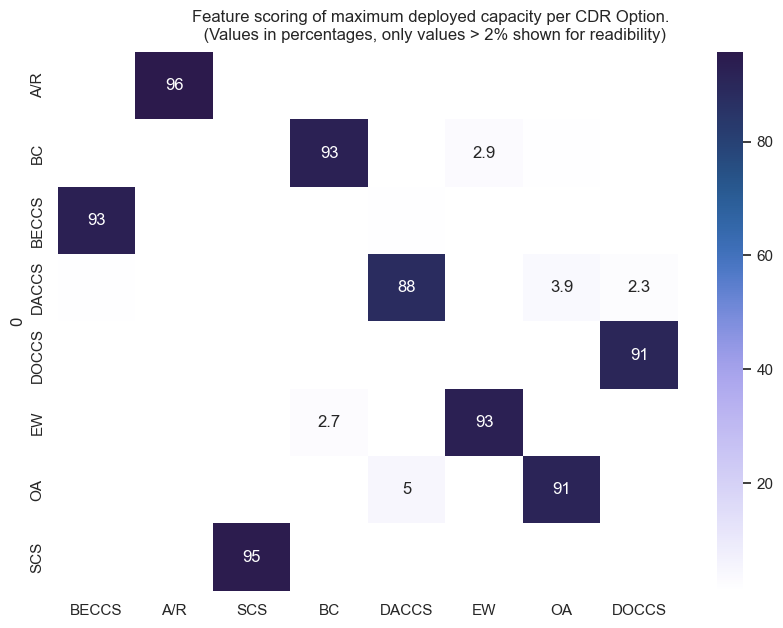

In [ ]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns
from cmcrameri import cm # https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf

#x = df_LHS.T
x = max_capacity.copy()
y = max_capacity.copy()

#x = x.drop([n for n in y.loc[pd.isna(y['A/R'])].index]) # Drop futures that were not solved
x = x.dropna()
y = y.dropna() # Drop futures that were not solved

fs_all = feature_scoring.get_feature_scores_all(x,y)
fs_all = fs_all.rename(index=Uncertainties)
fs_all = fs_all.div(0.01)

sns.set(font_scale=1)
plt.subplots(figsize=(10,7))
plt.suptitle('Feature scoring of maximum deployed capacity per CDR Option. \n (Values in percentages, only values > 2% shown for readibility)', size=12, y=0.94)
#dataplot = sns.heatmap(fs_all, annot=True,cmap=plt.get_cmap('PuBu'), vmin=0) # #cm.batlowW_r: Add '"_r" to cmap to reverse it https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib
dataplot = sns.heatmap(fs_all, annot=True,cmap=cm.devon_r, vmin=1) # cm.batlowW_r: Add '"_r" to cmap to reverse it https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib

for t in dataplot.texts: # How to annotate only valuea greater than x: https://stackoverflow.com/questions/66099438/how-to-annot-only-values-greater-than-x-on-a-seaborn-heatmap
    if float(t.get_text())>=2:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text(" ")

#plt.savefig('Figures_Results/Features_Drivers_allCDR_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")
plt.show()
plt.close('all')
#fs_all

#### General Feature Scoring: Relevant metrics (Removals & Costs & Resources)

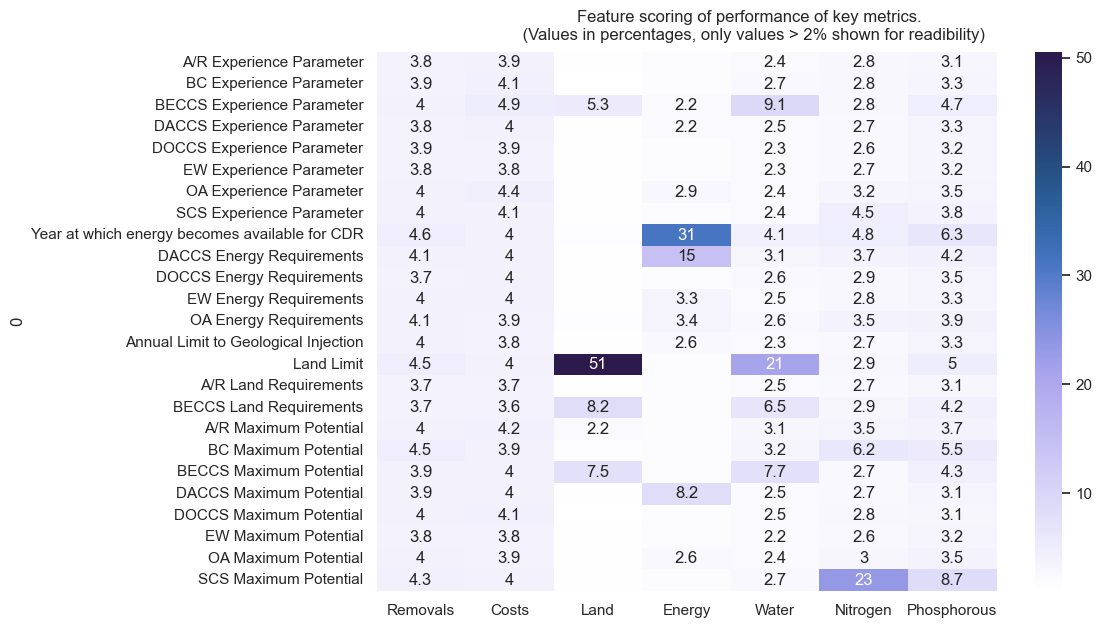

In [ ]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns
from cmcrameri import cm # https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf

#x = df_LHS.drop(['CDRRequired']).T
x = df_LHS.T
y = pd.concat([total_future, max_resources], axis = 1)

x = x.drop([n for n in y.loc[pd.isna(y['Costs'])].index]) # Drop futures that were not solved
y = y.dropna() # Drop futures that were not solved

fs_all = feature_scoring.get_feature_scores_all(x,y)
fs_all = fs_all.rename(index=Uncertainties)
fs_all = fs_all.div(0.01)

sns.set(font_scale=1)
plt.subplots(figsize=(10,7))
plt.suptitle('Feature scoring of performance of key metrics. \n (Values in percentages, only values > 2% shown for readibility)', size=12, y=0.94)
#dataplot = sns.heatmap(fs_all, annot=True,cmap=plt.get_cmap('PuBu'), vmin=0) # #cm.batlowW_r: Add '"_r" to cmap to reverse it https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib
dataplot = sns.heatmap(fs_all, annot=True,cmap=cm.devon_r, vmin=1) # cm.batlowW_r: Add '"_r" to cmap to reverse it https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib

for t in dataplot.texts: # How to annotate only valuea greater than x: https://stackoverflow.com/questions/66099438/how-to-annot-only-values-greater-than-x-on-a-seaborn-heatmap
    if float(t.get_text())>=2:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text(" ")

#plt.savefig('Figures_Results/Features_Drivers_allCDR_%s.png' %date.today().strftime("%d.%m.%Y"), format='png', transparent=True, bbox_inches="tight")
plt.show()
plt.close('all')
#fs_all